# Compare local thrombolysis decisions with *benchmark* decisions

Benchmark decisions are decisions made made my the majority of the top 30 hospitals as judged by their expected thrombolysis use in a standard 10K cohort of patients.

Aims:

* Predict thrombolysis use of 10K cohort of patients at all 132 hospitals.

* Get predicted thrombolysis decisions for all patients at the 30 benchmark hospitals.

* Check similarity between local decisions and benchmark decisions.

* Estimate thrombolysis use at each hospital if benchmark decisions made.

* Save comparison of local and benchmark decisions.

In [1]:
# Turn warnings off to keep notebook tidy
import warnings
warnings.filterwarnings("ignore")

import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import matplotlib.cm as cm
import matplotlib.colors as colors
from matplotlib.lines import Line2D

# sklearn for pre-processing
from sklearn.preprocessing import MinMaxScaler

# TensorFlow api model
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import backend as K
from tensorflow.keras.losses import binary_crossentropy

2022-06-12 17:21:03.434526: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1


## Load data on predicted 10K corhort thrombolysis use at each hospital

In [2]:
thrombolysis_by_hosp = pd.read_csv(
    './output/10k_thrombolysis_rate_by_hosp.csv', index_col='hospital')
thrombolysis_by_hosp.sort_values(
    '10k_thrombolysis', ascending=False, inplace=True)

In [3]:
thrombolysis_by_hosp.head()

,hospital.1,10k_thrombolysis,hosp_subnet_output,actual_thrombolysis
hospital,,,,
9,CNBGF2713O,0.4700,0.005932,0.470588
25,GKONI0110I,0.4409,0.119403,0.389831
62,MHMYL4920B,0.4388,0.126297,0.472727
32,HPWIF9956L,0.4292,0.163297,0.478261
53,KZKEZ2257Z,0.4147,0.206979,0.386555


In [4]:
top_30_hopsitals = list(thrombolysis_by_hosp.head(30).index)

## Define function to scale data

Scale input data 0-1 (MinMax scaling).

In [5]:
def scale_data(X_train, X_test):
    """Scale data 0-1 based on min and max in training set"""
    
    # Initialise a new scaling object for normalising input data
    sc = MinMaxScaler()

    # Set up the scaler just on the training set
    sc.fit(X_train)

    # Apply the scaler to the training and test sets
    train_sc = sc.transform(X_train)
    test_sc = sc.transform(X_test)
    
    return train_sc, test_sc

## Get predicted decision for all patients at each hopsital

Combine test results for k_fold data, so that all inviduals are predicted from a test set.

In [6]:
data_loc = '../data/kfold_5fold/'

train_data, test_data = [], []

for i in range(5):    
    train_data.append(pd.read_csv(data_loc + f'train_{i}.csv'))
    test_data.append(pd.read_csv(data_loc + f'test_{i}.csv'))

In [7]:
path = './saved_models/1d_modular/'

# Set up lists for observed and predicted
observed = []
predicted_proba = []
predicted = []

# Set up lists for observed and predicted
observed = []
predicted_proba = []
predicted = []

# Get data subgroups
subgroups = pd.read_csv('../data/subnet.csv', index_col='Item')
# Get list of clinical items
clinical_subgroup = subgroups.loc[subgroups['Subnet']=='clinical']
clinical_subgroup = list(clinical_subgroup.index)
# Get list of pathway items
pathway_subgroup = subgroups.loc[subgroups['Subnet']=='pathway']
pathway_subgroup = list(pathway_subgroup.index)
# Get list of hospital items
hospital_subgroup = subgroups.loc[subgroups['Subnet']=='hospital']
hospital_subgroup = list(hospital_subgroup.index)

# Loop through 5 k-folds
for k in range(5):
    
    # Load data
    train = pd.read_csv(f'../data/kfold_5fold/train_{k}.csv')
    test = pd.read_csv(f'../data/kfold_5fold/test_{k}.csv')
    
    # On first k, limit subgroups to fields present
    # Due to improved data selection in this repository    
    if k == 0:
        clinical_subgroup = [subgroup for subgroup in clinical_subgroup if 
                             subgroup in list(train)]
        pathway_subgroup = [subgroup for subgroup in pathway_subgroup if 
                            subgroup in list(train)]

    # OneHot encode stroke team
    coded = pd.get_dummies(train['StrokeTeam'])
    train = pd.concat([train, coded], axis=1)
    train.drop('StrokeTeam', inplace=True, axis=1)
    coded = pd.get_dummies(test['StrokeTeam'])
    test = pd.concat([test, coded], axis=1)
    test.drop('StrokeTeam', inplace=True, axis=1)
    
    # Split into X, y
    X_train_df = train.drop('S2Thrombolysis',axis=1) 
    y_train_df = train['S2Thrombolysis']
    X_test_df = test.drop('S2Thrombolysis',axis=1) 
    y_test_df = test['S2Thrombolysis'] 
    
    # Split train and test data by subgroups
    X_train_patients = X_train_df[clinical_subgroup]
    X_test_patients = X_test_df[clinical_subgroup]
    X_train_pathway = X_train_df[pathway_subgroup]
    X_test_pathway = X_test_df[pathway_subgroup]
    X_train_hospitals = X_train_df[hospital_subgroup]
    X_test_hospitals = X_test_df[hospital_subgroup]
            
    # Convert to NumPy
    X_train = X_train_df.values
    X_test = X_test_df.values
    y_train = y_train_df.values
    y_test = y_test_df.values
    
    # Scale data
    X_train_patients_sc, X_test_patients_sc = \
        scale_data(X_train_patients, X_test_patients)

    X_train_pathway_sc, X_test_pathway_sc = \
        scale_data(X_train_pathway, X_test_pathway)

    X_train_hospitals_sc, X_test_hospitals_sc = \
        scale_data(X_train_hospitals, X_test_hospitals)
    
    # Load model
    filename = f'{path}k_fold_model_{str(k)}.h5'
    model = keras.models.load_model(filename)
    
    # Get and store probablity
    probability = model.predict(
        [X_test_patients_sc, X_test_pathway_sc, X_test_hospitals_sc])
    y_pred_test = probability >= 0.5
    y_pred_test = y_pred_test.flatten() *1
    predicted.append(y_pred_test)    
    
    observed.append(y_test)
    predicted_proba.append(probability.flatten())

    # Print accuracy
    accuracy = np.mean(y_pred_test == y_test)
    print(
        f'Run {k+1}, accuracy: {accuracy:0.3f}')

2022-06-12 17:21:06.442785: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-06-12 17:21:06.443577: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2022-06-12 17:21:06.505962: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:21:00.0 name: Quadro P4000 computeCapability: 6.1
coreClock: 1.48GHz coreCount: 14 deviceMemorySize: 7.92GiB deviceMemoryBandwidth: 226.62GiB/s
2022-06-12 17:21:06.506028: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
2022-06-12 17:21:06.509026: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.10
2022-06-12 17:21:06.509144: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublasLt.so.10
2022-06-12

Run 1, accuracy: 0.852
Run 2, accuracy: 0.858
Run 3, accuracy: 0.851
Run 4, accuracy: 0.857
Run 5, accuracy: 0.850


Combine test results in a dataframe.

In [8]:
thrombolysis_predictions_at_own_unit_k_fold = []

for i in range(5):
    df = pd.DataFrame()
    df['unit'] = test_data[i]['StrokeTeam']
    df['observed'] = observed[i]
    df['predicted_thrombolysis'] = predicted[i]
    df['predicted_proba'] = predicted_proba[i]
    thrombolysis_predictions_at_own_unit_k_fold.append(df)
    
thrombolysis_predictions_at_own_unit = pd.concat(
    thrombolysis_predictions_at_own_unit_k_fold, axis=0)

## Get predictions at 30 benchmark hospitals

Use k-fold split data to get predictions for all patients (who are present in the 5 k-fold test sets). Get predicted thrombolysis decisions for all patients at the 30 benchmark hospitals.

In [9]:
hospitals = top_30_hopsitals
top_30_predictions = []

# Get data subgroups
subgroups = pd.read_csv('../data/subnet.csv', index_col='Item')
# Get list of clinical items
clinical_subgroup = subgroups.loc[subgroups['Subnet']=='clinical']
clinical_subgroup = list(clinical_subgroup.index)
# Get list of pathway items
pathway_subgroup = subgroups.loc[subgroups['Subnet']=='pathway']
pathway_subgroup = list(pathway_subgroup.index)
# Get list of hospital items
hospital_subgroup = subgroups.loc[subgroups['Subnet']=='hospital']
hospital_subgroup = list(hospital_subgroup.index)

# Loop through k folds
for k_fold in range(5):
    
    k_fold_predictions = []
    
    # Load model
    path = './saved_models/1d_modular/'
    filename = f'{path}k_fold_model_{str(k_fold)}.h5'
    model = keras.models.load_model(filename)
    
    # Get k fold split
    train = train_data[k_fold]
    test = test_data[k_fold]

    # If k=0, limit subgroups to fields present
    # Due to improved data selection in this repository
    if k_fold == 0:
        clinical_subgroup = [subgroup for subgroup in clinical_subgroup if 
                             subgroup in list(train)]
        pathway_subgroup = [subgroup for subgroup in pathway_subgroup if 
                            subgroup in list(train)]

    # OneHot encode stroke team
    coded = pd.get_dummies(train['StrokeTeam'])
    train = pd.concat([train, coded], axis=1)
    train.drop('StrokeTeam', inplace=True, axis=1)
    coded = pd.get_dummies(test['StrokeTeam'])
    test = pd.concat([test, coded], axis=1)
    test.drop('StrokeTeam', inplace=True, axis=1)

    # Split into X, y
    X_train_df = train.drop('S2Thrombolysis',axis=1) 
    y_train_df = train['S2Thrombolysis']
    X_test_df = test.drop('S2Thrombolysis',axis=1) 
    y_test_df = test['S2Thrombolysis'] 

    # Split train and test data by subgroups
    X_train_patients = X_train_df[clinical_subgroup]
    X_test_patients = X_test_df[clinical_subgroup]
    X_train_pathway = X_train_df[pathway_subgroup]
    X_test_pathway = X_test_df[pathway_subgroup]
    X_train_hospitals = X_train_df[hospital_subgroup]
    X_test_hospitals = X_test_df[hospital_subgroup]

    # Convert to NumPy
    X_train = X_train_df.values
    X_test = X_test_df.values
    y_train = y_train_df.values
    y_test = y_test_df.values

    # Scale data
    X_train_patients_sc, X_test_patients_sc = \
        scale_data(X_train_patients, X_test_patients)

    X_train_pathway_sc, X_test_pathway_sc = \
        scale_data(X_train_pathway, X_test_pathway)

    X_train_hospitals_sc, X_test_hospitals_sc = \
        scale_data(X_train_hospitals, X_test_hospitals)
    
    # Get number of hospitals
    num_hospitals = len(X_test_hospitals_sc[0])
    
    # Create test array for changing hospital ID
    X_hospitals_alter = X_test_hospitals_sc.copy()
    
    # Get classification for all patients at all hospials
    patient_results = []
     
    # Loop through setting hospital
    hospital_results = []
    
    for hosp in hospitals:        
        
        # Set all hospitals to zero
        X_hospitals_alter[:,:] = 0
        
        # Set test hospital to 1
        X_hospitals_alter[:,hosp] = 1
        
        # Get probability of thrombolysis
        probability = model.predict(
            [X_test_patients_sc, X_test_pathway_sc, X_hospitals_alter])
        
        # Classify
        classified = probability >= 0.5
        patient_results.append(classified)
        
        # Store
        k_fold_predictions.append(classified * 1)

    top_30_predictions.append(k_fold_predictions)
    
    print(f'K-fold {k_fold+1} complete')

K-fold 1 complete
K-fold 2 complete
K-fold 3 complete
K-fold 4 complete
K-fold 5 complete


Reformat top 30 hospital predictions.

top_30_predictions has [a][b][c] where:
[a] = k_fold
[b] = hospital
[c] = individual

In [10]:
benchmark_decisions_k_fold = []

for i in range(5):
    df = pd.DataFrame()
    df['home_unit'] = test_data[i]['StrokeTeam']
    k_fold_predictions = top_30_predictions[i][:][:]    
    benchmark_yes_count = np.array(k_fold_predictions).sum(axis=0)
    df['majority_vote'] = (benchmark_yes_count >= 15) * 1.0
    benchmark_decisions_k_fold.append(df)
    
benchmark_decisions = pd.concat(benchmark_decisions_k_fold,  axis=0)

In [11]:
benchmark_decisions.head()

,home_unit,majority_vote
0,TXHRP7672C,1.0
1,SQGXB9559U,1.0
2,LFPMM4706C,0.0
3,MHMYL4920B,0.0
4,EQZZZ5658G,1.0


In [12]:
thrombolysis_predictions_at_own_unit['majority_vote'] = \
    benchmark_decisions['majority_vote']

In [13]:
thrombolysis_predictions_at_own_unit.head()

,unit,observed,predicted_thrombolysis,predicted_proba,majority_vote
0,TXHRP7672C,1,1,0.774167,1.0
1,SQGXB9559U,1,1,0.606846,1.0
2,LFPMM4706C,0,0,0.115273,0.0
3,MHMYL4920B,0,0,0.054328,0.0
4,EQZZZ5658G,1,1,0.889842,1.0


## Check similarity of own decisions vs benchmark decisions.

In [14]:
same_decision = (
    thrombolysis_predictions_at_own_unit['observed'] == 
    thrombolysis_predictions_at_own_unit['majority_vote'])

In [15]:
print(f'Proportion same decision {same_decision.mean():0.3f}')

Proportion same decision 0.831


## Count number thrombolysed at each hospital compared with benchmark

In [16]:
thrombolysis_counts = (thrombolysis_predictions_at_own_unit.groupby('unit').agg('sum').drop(
        'predicted_proba', axis=1))

In [17]:
thrombolysis_counts.head()

,observed,predicted_thrombolysis,majority_vote
unit,,,
AGNOF1041H,307,338,408.0
AKCGO9726K,528,562,566.0
AOBTM3098N,128,119,207.0
APXEE8191H,130,131,182.0
ATDID5461S,75,68,108.0


In [18]:
change = (thrombolysis_counts['majority_vote'].sum() / 
          thrombolysis_counts['observed'].sum())

print (f'Change in thrombolysis with benchmark vote: {change:0.3f}')

Change in thrombolysis with benchmark vote: 1.274


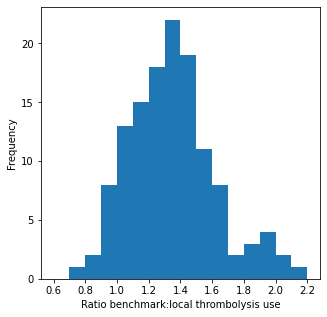

In [19]:
fig = plt.figure(figsize=(5,5))
ax = fig.add_subplot()
ratio = thrombolysis_counts['majority_vote'] / thrombolysis_counts['observed']
ax.hist(ratio, bins = np.arange(0.6, 2.3, 0.1))
ax.set_xlabel('Ratio benchmark:local thrombolysis use')
ax.set_ylabel('Frequency')
plt.show()

## Add patient counts at units, and calculate thrombolysis rate

In [20]:
unit_count = thrombolysis_predictions_at_own_unit.groupby(
    'unit').count()['observed']

In [21]:
thrombolysis_counts['patients'] = unit_count
thrombolysis_counts['observed_rate'] = (
    thrombolysis_counts['observed'] / thrombolysis_counts['patients'])
thrombolysis_counts['benchmark_rate'] = (
    thrombolysis_counts['majority_vote'] / thrombolysis_counts['patients'])

Add benchmark label

In [22]:
thrombolysis_counts['benchmark_unit'] = False
thrombolysis_counts['benchmark_unit'].iloc[top_30_hopsitals] = True

In [23]:
thrombolysis_counts

,observed,predicted_thrombolysis,majority_vote,patients,observed_rate,benchmark_rate,benchmark_unit
unit,,,,,,,
AGNOF1041H,307,338,408.0,871,0.352468,0.468427,False
AKCGO9726K,528,562,566.0,1428,0.369748,0.396359,True
AOBTM3098N,128,119,207.0,585,0.218803,0.353846,False
APXEE8191H,130,131,182.0,574,0.226481,0.317073,False
ATDID5461S,75,68,108.0,312,0.240385,0.346154,False
...,...,...,...,...,...,...,...
YPKYH1768F,78,78,115.0,317,0.246057,0.362776,False
YQMZV4284N,111,112,121.0,470,0.236170,0.257447,True
ZBVSO0975W,108,108,173.0,432,0.250000,0.400463,False


In [24]:
thrombolysis_counts.head()

,observed,predicted_thrombolysis,majority_vote,patients,observed_rate,benchmark_rate,benchmark_unit
unit,,,,,,,
AGNOF1041H,307,338,408.0,871,0.352468,0.468427,False
AKCGO9726K,528,562,566.0,1428,0.369748,0.396359,True
AOBTM3098N,128,119,207.0,585,0.218803,0.353846,False
APXEE8191H,130,131,182.0,574,0.226481,0.317073,False
ATDID5461S,75,68,108.0,312,0.240385,0.346154,False


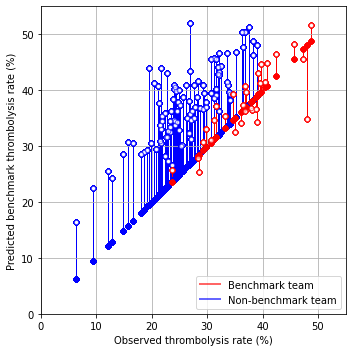

In [28]:
fig = plt.figure(figsize=(5,5))
ax = fig.add_subplot()

# Plot non-benchmark hospitals in blue
mask = thrombolysis_counts['benchmark_unit'] == False
non_bench = thrombolysis_counts[mask]

for i, val in non_bench.iterrows():
    start = [non_bench['observed_rate'] * 100,
             non_bench['observed_rate'] * 100]
    end = [non_bench['observed_rate'] * 100,
             non_bench['benchmark_rate'] * 100]
    ax.plot(start, end, c='b', lw=1, zorder=1)
    ax.scatter(start[0], start[1], marker='o', facecolors='b', edgecolors='b', 
               s=20, zorder=2, alpha=0.6)
    ax.scatter(end[0], end[1], marker='o', facecolors='w', edgecolors='b',
               s=20, zorder=2, alpha=0.6)

# Plot benchmark hospitals in red
mask = thrombolysis_counts['benchmark_unit'] == True
bench = thrombolysis_counts[mask]

for i, val in bench.iterrows():
    start = [bench['observed_rate'] * 100,
             bench['observed_rate'] * 100]
    end = [bench['observed_rate'] * 100,
             bench['benchmark_rate'] * 100]
    ax.plot(start, end, c='r', lw=1, zorder=1)
    ax.scatter(start[0], start[1], marker='o', facecolors='r', edgecolors='r', 
               s=20, zorder=2, alpha=0.6)
    ax.scatter(end[0], end[1], marker='o', facecolors='w', edgecolors='r',
               s=20, zorder=2, alpha=0.6)

# Add mods 
ax.set_xlabel('Observed thrombolysis rate (%)')
ax.set_ylabel('Predicted benchmark thrombolysis rate (%)')
ax.set_xlim(0, 55)
ax.set_ylim(0, 55)
ax.grid()

custom_lines = [Line2D([0], [0], color='r', alpha=0.6, lw=2),
                Line2D([0], [0], color='b', alpha=0.6, lw=2)]

plt.legend(custom_lines, ['Benchmark team', 'Non-benchmark team'],
          loc='lower right')

plt.tight_layout()
plt.savefig('output/benchmark_thrombolysis.jpg', dpi=300)

plt.show()

## Save comparisons of decisions

In [26]:
thrombolysis_predictions_at_own_unit.to_csv(
    './predictions/benchmark_decisions_1d_modular.csv', index=False)

In [27]:
test_collated = pd.concat(test_data, axis=0)
test_collated.to_csv('./predictions/test_features_collated.csv', index=False)

## Observations

* 83.1% decisions are identical between local and benchmark decisions.
* Thrombolysis use would be increased 27.4% if benchmark decisions were made at all hospitals.
* The ration of benchmark:local thrombolysis use was 0.7 to 2.2.